In [1]:
import os
import re
import time
import whois
import pickle
import random
import requests
import ipaddress
import numpy as np
import dns.resolver
import pandas as pd
import seaborn as sns
import tensorflow as tf
import concurrent.futures
from datetime import datetime
from urllib.parse import urlparse
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten, BatchNormalization

2025-02-12 16:03:36.977208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress most TensorFlow logs


## Data Loading

In [3]:
# Specify the file name or path
input_file = 'Data_gen/data_output/phishing_email_dataset.csv'  # Replace with the path to your .csv file

# Load the CSV into a DataFrame
df = pd.read_csv(input_file)

# Display the first few rows of the DataFrame
print(df.head())

                 sender              receiver        date  \
0  kt4makf7@hotmail.com    zz4pcd76@gmail.com  2019-02-19   
1  qpsu80x5@outlook.com  hivq6q6n@outlook.com  2021-04-23   
2    tsr596ly@gmail.com  hutnj7f9@hotmail.com  2019-02-01   
3    p6x3hskt@gmail.com    rn9xj56s@yahoo.com  2020-02-01   
4    kyni1nhy@gmail.com    afn53n7r@gmail.com  2022-01-21   

                 subject                                               body  \
0  Urgent Account Notice  Greetings,\n\nCongratulations! You are eligibl...   
1    Your Account Update  Dear Valued Customer,\n\nWe hope you're enjoyi...   
2  Urgent Account Notice  Attention,\n\nYour account password has been c...   
3    Your Account Update  Greetings,\n\nThank you for subscribing to our...   
4    Your Account Update  Hi,\n\nWe noticed you changed your account set...   

                                             urls  label  
0                  http://wyyrdcefgl.duckdns.org/      1  
1                          https://examp

In [4]:
# Remove rows where the 'url' column contains the specific value
df = df[df['urls'] != 'https://hrijg.zlcc0626.cn/']
df = df[df['urls'] != 'https://hello-world-long-lab-f788.fdsgds-b06.workers.dev/']
df = df[df['urls'] != 'https://example982.com']
df = df[df['urls'] != 'https://example191.com']
df = df[df['urls'] != 'http://ezxxaefdjk.duckdns.org/']

In [5]:
df.shape

(439564, 7)

In [6]:
#Verifying Balance dataset or not
# Load the balanced dataset
balanced_df = pd.read_csv("Data_gen/data_output/phishing_email_dataset.csv")

# Check label distribution
print(balanced_df['label'].value_counts())


label
1    220006
0    220006
Name: count, dtype: int64


In [7]:
# check the summary of statistics for all the columns in a DataFrame that have an object data type. 
df.describe(include=["object"])

,sender,receiver,date,subject,body,urls
count,439564,439564,439564,439564,439564,439564
unique,439564,439564,2191,2,221709,212606
top,kt4makf7@hotmail.com,zz4pcd76@gmail.com,2021-07-23,Urgent Account Notice,"Greetings,\n\nThank you for subscribing to our...",https://example216.com
freq,1,1,251,220001,83,271


In [8]:
df.head()

,sender,receiver,date,subject,body,urls,label
0,kt4makf7@hotmail.com,zz4pcd76@gmail.com,2019-02-19,Urgent Account Notice,"Greetings,\n\nCongratulations! You are eligibl...",http://wyyrdcefgl.duckdns.org/,1
1,qpsu80x5@outlook.com,hivq6q6n@outlook.com,2021-04-23,Your Account Update,"Dear Valued Customer,\n\nWe hope you're enjoyi...",https://example397.com,0
2,tsr596ly@gmail.com,hutnj7f9@hotmail.com,2019-02-01,Urgent Account Notice,"Attention,\n\nYour account password has been c...",https://www4.netstation-aplcuos.com/login.html,1
3,p6x3hskt@gmail.com,rn9xj56s@yahoo.com,2020-02-01,Your Account Update,"Greetings,\n\nThank you for subscribing to our...",https://example922.com,0
4,kyni1nhy@gmail.com,afn53n7r@gmail.com,2022-01-21,Your Account Update,"Hi,\n\nWe noticed you changed your account set...",https://example505.com,0


## Data Cleaning

In [9]:
df['label'].unique()

array([1, 0])

In [10]:
# Remove rows where sender or receiver is blank or contains 'Unknown'
df = df[(df['sender'].str.strip() != "") & (df['sender'] != "Unknown") & (df['receiver'].str.strip() != "") & (df['receiver'] != "Unknown")]


In [11]:
# Recheck for missing values in each column
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
sender      0
receiver    0
date        0
subject     0
body        0
urls        0
label       0
dtype: int64


In [12]:
    
# Remove rows where any column is blank
df = df[~(df.apply(lambda x: x.astype(str).str.strip() == "")).any(axis=1)]

In [13]:
# Recheck for missing values in each column
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
sender      0
receiver    0
date        0
subject     0
body        0
urls        0
label       0
dtype: int64


In [14]:
# Drop all rows with missing (NaN) values
df.dropna(inplace=True)

In [15]:
# Recheck for missing values in each column
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
sender      0
receiver    0
date        0
subject     0
body        0
urls        0
label       0
dtype: int64


In [16]:
df.shape

(439564, 7)

In [17]:
df.head()

,sender,receiver,date,subject,body,urls,label
0,kt4makf7@hotmail.com,zz4pcd76@gmail.com,2019-02-19,Urgent Account Notice,"Greetings,\n\nCongratulations! You are eligibl...",http://wyyrdcefgl.duckdns.org/,1
1,qpsu80x5@outlook.com,hivq6q6n@outlook.com,2021-04-23,Your Account Update,"Dear Valued Customer,\n\nWe hope you're enjoyi...",https://example397.com,0
2,tsr596ly@gmail.com,hutnj7f9@hotmail.com,2019-02-01,Urgent Account Notice,"Attention,\n\nYour account password has been c...",https://www4.netstation-aplcuos.com/login.html,1
3,p6x3hskt@gmail.com,rn9xj56s@yahoo.com,2020-02-01,Your Account Update,"Greetings,\n\nThank you for subscribing to our...",https://example922.com,0
4,kyni1nhy@gmail.com,afn53n7r@gmail.com,2022-01-21,Your Account Update,"Hi,\n\nWe noticed you changed your account set...",https://example505.com,0


In [18]:
#df.describe() method in pandas provides a summary of statistics for numerical columns in the DataFrame by default.
df.describe()

,label
count,439564.000000
mean,0.500498
std,0.500000
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 439564 entries, 0 to 440011
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sender    439564 non-null  object
 1   receiver  439564 non-null  object
 2   date      439564 non-null  object
 3   subject   439564 non-null  object
 4   body      439564 non-null  object
 5   urls      439564 non-null  object
 6   label     439564 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 26.8+ MB


In [20]:
# Convert 'sender' and 'receiver' to categorical codes
df['sender'] = df['sender'].astype('category').cat.codes
df['receiver'] = df['receiver'].astype('category').cat.codes

In [21]:
# Convert categorical columns to numeric
df['sender'] = df['sender'].astype('category').cat.codes
df['receiver'] = df['receiver'].astype('category').cat.codes
df['label'] = df['label'].astype('category').cat.codes

In [22]:
# Convert 'date' to a numeric timestamp
df['date'] = pd.to_datetime(df['date'], errors='coerce').astype('int64', errors='ignore')

In [23]:
# Convert 'label' to categorical codes
df['label'] = df['label'].astype('category').cat.codes

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 439564 entries, 0 to 440011
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sender    439564 non-null  int32 
 1   receiver  439564 non-null  int32 
 2   date      439564 non-null  int64 
 3   subject   439564 non-null  object
 4   body      439564 non-null  object
 5   urls      439564 non-null  object
 6   label     439564 non-null  int8  
dtypes: int32(2), int64(1), int8(1), object(3)
memory usage: 20.5+ MB


In [25]:
#extract the urls fro body column and add the urls to the extracted_url column
#    Address Bar based Features
#    Domain based Features
#    HTML & Javascript based Features
# Function to extract the first URL from the body

def extract_url(text):
    url_pattern = r'(https?://\S+)'  # Regex pattern to find URLs
    match = re.search(url_pattern, str(text))
    return match.group(0) if match else None

# Apply the function to create a new 'extracted_url' column
df['extracted_url'] = df['body'].apply(extract_url)
df.dropna(subset=['extracted_url'], inplace=True)

In [26]:
df.head()

,sender,receiver,date,subject,body,urls,label,extracted_url
0,253920,439286,1550534400000000000,Urgent Account Notice,"Greetings,\n\nCongratulations! You are eligibl...",http://wyyrdcefgl.duckdns.org/,1,http://wyyrdcefgl.duckdns.org/
1,326005,213645,1619136000000000000,Your Account Update,"Dear Valued Customer,\n\nWe hope you're enjoyi...",https://example397.com,0,https://example397.com
2,363613,217661,1548979200000000000,Urgent Account Notice,"Attention,\n\nYour account password has been c...",https://www4.netstation-aplcuos.com/login.html,1,https://www4.netstation-aplcuos.com/login.html
3,307686,337393,1580515200000000000,Your Account Update,"Greetings,\n\nThank you for subscribing to our...",https://example922.com,0,https://example922.com
4,255799,126935,1642723200000000000,Your Account Update,"Hi,\n\nWe noticed you changed your account set...",https://example505.com,0,https://example505.com


In [27]:
print("Total extracted URLs:", df['extracted_url'].notnull().sum())


Total extracted URLs: 439557


In [28]:
# Check for missing values in the 'label' column
missing_labels = df['label'].isnull().sum()
print(f"Missing values in 'label' column: {missing_labels}")

Missing values in 'label' column: 0


In [29]:
# Function to generate relevant URLs based on sender's domain
#def generate_relevant_url(sender):
#    if pd.isna(sender) or "@" not in str(sender):print(df['body'].isnull().sum())
#        return "https://generic-placeholder.com"
#    domain = str(sender).split("@")[-1].split(".")[0]  # Extract domain name
#    return f"https://{domain}.com/login"

# Fill missing 'extracted_url' values with relevant URLs
#df['extracted_url'] = df.apply(lambda row: generate_relevant_url(row['sender']) if pd.isna(row['extracted_url']) else row['extracted_url'], axis=1)


In [30]:
# Ensure label column is numeric and assign label 0 to imputed rows
#df['label'] = df['label'].fillna(0).astype(int)

# Check for missing values in the 'label' column
#missing_labels = df['label'].isnull().sum()
#print(f"Missing values in 'label' column: {missing_labels}")

In [31]:
print("Total extracted URLs:", df['extracted_url'].notnull().sum())


Total extracted URLs: 439557


In [32]:
# Check for missing values in the 'label' column
missing_labels = df['label'].isnull().sum()
print(f"Missing values in 'label' column: {missing_labels}")

Missing values in 'label' column: 0


In [33]:
# Fill missing values in the 'date' column with today's date
df['date'] = df['date'].fillna(datetime.today().strftime('%Y-%m-%d'))


In [34]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 sender           0
receiver         0
date             0
subject          0
body             0
urls             0
label            0
extracted_url    0
dtype: int64


In [35]:
df.head()

,sender,receiver,date,subject,body,urls,label,extracted_url
0,253920,439286,1550534400000000000,Urgent Account Notice,"Greetings,\n\nCongratulations! You are eligibl...",http://wyyrdcefgl.duckdns.org/,1,http://wyyrdcefgl.duckdns.org/
1,326005,213645,1619136000000000000,Your Account Update,"Dear Valued Customer,\n\nWe hope you're enjoyi...",https://example397.com,0,https://example397.com
2,363613,217661,1548979200000000000,Urgent Account Notice,"Attention,\n\nYour account password has been c...",https://www4.netstation-aplcuos.com/login.html,1,https://www4.netstation-aplcuos.com/login.html
3,307686,337393,1580515200000000000,Your Account Update,"Greetings,\n\nThank you for subscribing to our...",https://example922.com,0,https://example922.com
4,255799,126935,1642723200000000000,Your Account Update,"Hi,\n\nWe noticed you changed your account set...",https://example505.com,0,https://example505.com


In [36]:
#Remove the rows with missing vaues 
#df = df.dropna(subset=['extracted_url'])

In [37]:
df.head()

,sender,receiver,date,subject,body,urls,label,extracted_url
0,253920,439286,1550534400000000000,Urgent Account Notice,"Greetings,\n\nCongratulations! You are eligibl...",http://wyyrdcefgl.duckdns.org/,1,http://wyyrdcefgl.duckdns.org/
1,326005,213645,1619136000000000000,Your Account Update,"Dear Valued Customer,\n\nWe hope you're enjoyi...",https://example397.com,0,https://example397.com
2,363613,217661,1548979200000000000,Urgent Account Notice,"Attention,\n\nYour account password has been c...",https://www4.netstation-aplcuos.com/login.html,1,https://www4.netstation-aplcuos.com/login.html
3,307686,337393,1580515200000000000,Your Account Update,"Greetings,\n\nThank you for subscribing to our...",https://example922.com,0,https://example922.com
4,255799,126935,1642723200000000000,Your Account Update,"Hi,\n\nWe noticed you changed your account set...",https://example505.com,0,https://example505.com


In [38]:
df.shape

(439557, 8)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 439557 entries, 0 to 440011
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   sender         439557 non-null  int32 
 1   receiver       439557 non-null  int32 
 2   date           439557 non-null  int64 
 3   subject        439557 non-null  object
 4   body           439557 non-null  object
 5   urls           439557 non-null  object
 6   label          439557 non-null  int8  
 7   extracted_url  439557 non-null  object
dtypes: int32(2), int64(1), int8(1), object(4)
memory usage: 23.9+ MB


In [40]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)  # Convert to UTC timezone
df['date'] = df['date'].dt.tz_localize(None)  # Remove timezone info
df['date'] = df['date'].astype(int) / 10**9  # Convert to UNIX timestamp (seconds)
df['date'] = pd.to_datetime(df['date'], errors='coerce').astype(int) / 10**9  # Convert to seconds

In [41]:
#from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Limit to 100 most important words

# Convert 'subject' and 'body' to TF-IDF features
#subject_tfidf = tfidf_vectorizer.fit_transform(df['subject'].astype(str)).toarray()
#body_tfidf = tfidf_vectorizer.fit_transform(df['body'].astype(str)).toarray()

# Convert to DataFrame
#subject_tfidf_df = pd.DataFrame(subject_tfidf, columns=[f"subject_{i}" for i in range(subject_tfidf.shape[1])])
#body_tfidf_df = pd.DataFrame(body_tfidf, columns=[f"body_{i}" for i in range(body_tfidf.shape[1])])

# Drop original text columns and merge new features
#df = df.drop(columns=['subject', 'body'])
#df = pd.concat([df.reset_index(drop=True), subject_tfidf_df, body_tfidf_df], axis=1)


In [42]:
print(df.dtypes)  # Ensure all columns are now numeric


sender             int32
receiver           int32
date             float64
subject           object
body              object
urls              object
label               int8
extracted_url     object
dtype: object


In [43]:
#df = df.apply(pd.to_numeric, errors='coerce')  # Convert all to numeric
#df.fillna(0, inplace=True)  # Replace NaN with 0
df['body'] = df['body'].astype(str) #convert to sring type

In [44]:
print(df.dtypes)  # Ensure all columns are now numeric


sender             int32
receiver           int32
date             float64
subject           object
body              object
urls              object
label               int8
extracted_url     object
dtype: object


In [45]:
print("Columns in the DataFrame:", df.columns)


Columns in the DataFrame: Index(['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label',
       'extracted_url'],
      dtype='object')


In [46]:
# Save the cleaned DataFrame to a CSV file

import os
from datetime import datetime

# Generate a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Ensure the "saved_models" directory exists
os.makedirs("saved_data", exist_ok=True)
df.to_csv(f"saved_data/DATA-Clearning-Cleaned_Data_{timestamp}.csv", index=False)

print(f"Cleaned dataframe saved to DATA-Clearning-Cleaned_Data_{timestamp}.csv")

Cleaned dataframe saved to DATA-Clearning-Cleaned_Data_20250212_160342.csv


## Feature Engineering

    Extract text-based features (e.g., length of email body, number of special characters, presence of urgent words).
    Analyze URLs:
        Extract domain and check if it appears in known phishing databases.
        Count number of dots (.), hyphens (-), and special characters.
    Use Natural Language Processing (NLP) to analyze body content for phishing indicators.
1. Address Bar based Features (Domain of URL, IP Address in URL, "@" Symbol in URL, Length of URL, Depth of URL, Redirection "//" in URL, "http/https" in Domain name, Using URL Shortening Services “TinyURL”, Prefix or Suffix "-" in Domain)

2. Domain based Features(DNS Record, Website Traffic, Age of Domain, End Period of Domain )

3. HTML & Javascript based Features( IFrame Redirection, Status Bar Customization, Disabling Right Click, Website Forwarding)

In [47]:
# Function to check if a URL is in phishing databases
#def check_phishing_url(url):
#    if pd.isna(url):
#        return 0
#    for db_url in PHISHING_DATABASES:
#        try:
#            response = requests.get(db_url)
#            if url in response.text:
#                return 1
#        except:
#            continue
#    return 0

#df['is_phishing_url'] = df['extracted_url'].apply(check_phishing_url)


In [48]:
# Function to check if an IP address is in phishing databases
#def check_phishing_ip(ip):
#    if pd.isna(ip) or ip == "0":
#        return 0
#    for db_url in PHISHING_DATABASES:
#        try:
#            response = requests.get(db_url)
#            if ip in response.text:
#                return 1
#        except:
#            continue
#    return 0



In [49]:
# Function to extract IP from URL
def extract_ip_from_url(url):
    try:
        parsed_url = urlparse(url)
        domain = parsed_url.netloc
        if re.match(r'^([0-9]{1,3}\.){3}[0-9]{1,3}$', domain) or re.match(r'^([0-9a-fA-F:]+)$', domain):
            return domain  # Return IP if domain is an IP address
    except:
        return "0"
    return "0"

# Apply IP extraction and phishing check
df['extracted_ip'] = df['extracted_url'].apply(extract_ip_from_url)
#df['is_phishing_ip'] = df['extracted_ip'].apply(check_phishing_ip)


In [50]:
# Import necessary libraries
import pandas as pd
import ipaddress

# Function to clean and parse URLs safely
def clean_url(url):
    if pd.isna(url) or not isinstance(url, str) or len(url.strip()) == 0:
        return None  # Return None for missing or empty URLs
    url = url.strip().strip('[]')  # Remove any unwanted brackets
    return url

# Function to check if the domain is an IP address (IPv4 or IPv6)
def is_ip_address(domain):
    try:
        ipaddress.ip_address(domain)  # Correct indentation and syntax
        return 1  # It is an IP address
    except ValueError:
        return 0  # Not an IP address


In [51]:
from urllib.parse import urlparse

# Function to check if the domain is an IP address
def is_ip_address(domain):
    import re
    ip_pattern = re.compile(r"(\d{1,3}\.){3}\d{1,3}$")  # IPv4 regex
    return 1 if ip_pattern.match(domain) else 0

# Function to clean URLs (placeholder, define as needed)
def clean_url(url):
    return url.strip() if isinstance(url, str) else None

# Function to extract URL-based features
def extract_url_features(url):
    url = clean_url(url)
    if url is None:
        return [0] * 9  # Return a list of zeros for missing or invalid URLs

    try:
        parsed_url = urlparse(url)
        netloc = parsed_url.netloc.lower().strip()  # Normalize the domain part

        shortening_services = (
            "bit.ly", "tinyurl.com", "is.gd", "goo.gl", "shorte.st", "go2l.ink", "x.co", 
            "ow.ly", "t.co", "tr.im", "cli.gs", "yfrog.com", "migre.me", "ff.im", 
            "tiny.cc", "url4.eu", "twit.ac", "su.pr", "twurl.nl", "snipurl.com", 
            "short.to", "BudURL.com", "ping.fm", "post.ly", "Just.as", "bkite.com", 
            "snipr.com", "fic.kr", "loopt.us", "doiop.com", "short.ie", "kl.am", 
            "wp.me", "rubyurl.com", "om.ly", "to.ly", "bit.do", "lnkd.in", "db.tt", 
            "qr.ae", "adf.ly", "bitly.com", "cur.lv", "ity.im", "q.gs", "po.st", 
            "bc.vc", "twitthis.com", "u.to", "j.mp", "buzurl.com", "cutt.us", 
            "u.bb", "yourls.org", "x.co", "prettylinkpro.com", "scrnch.me", 
            "filoops.info", "vzturl.com", "qr.net", "1url.com", "tweez.me", 
            "v.gd", "link.zip.net"
        )

        return [
            len(url),  # URL length
            url.count('/'),  # URL depth
            1 if '@' in url else 0,  # Presence of '@'
            1 if '-' in netloc else 0,  # Presence of '-'
            1 if netloc.count('.') > 1 else 0,  # Subdomain count
            1 if parsed_url.scheme != 'https' else 0,  # Use of HTTP instead of HTTPS
            1 if '//' in url[7:] else 0,  # Redirection "//"
            1 if any(service in netloc for service in shortening_services) else 0,  # URL Shortener
            is_ip_address(netloc)  # Check if domain is an IP (IPv4 or IPv6)
        ]
    except Exception as e:
        print(f"Error processing URL {url}: {e}")
        return [0] * 9  # Return default values in case of errors

# Ensure no missing values in 'extracted_url' before applying the function
df = df.dropna(subset=['extracted_url'])

# Apply the feature extraction function safely
df[['url_length', 'url_depth', 'has_at_symbol', 'has_hyphen', 'subdomain_count', 
    'is_http', 'has_redirection', 'is_shortened', 'has_ip']] = df['extracted_url'].apply(
        lambda x: pd.Series(extract_url_features(str(x)))
    )


In [52]:
#drop the extracted_url column
df.drop(columns=['extracted_url'], inplace=True)


In [53]:
# Drop 'extracted_ip' as it is no longer needed
df.drop(columns=['extracted_ip'], inplace=True)
print("Dropped 'extracted_ip' column after extracting relevant features.")


Dropped 'extracted_ip' column after extracting relevant features.


In [54]:
#new code 

# 1. Extract URL Features
#def is_ip_address(domain):
#    try:
#        ipaddress.ip_address(domain)
#        return 1  # It is an IP address
#    except ValueError:
#        return 0  # Not an IP address
#
#def extract_url_features(url):
#    if pd.isna(url):
#        return [0] * 10
#    parsed_url = urlparse(url)
#    netloc = parsed_url.netloc.lower().strip()
#    shortening_services = ("bit.ly", "tinyurl.com", "is.gd", "goo.gl")
#    return [
#        len(url),  # URL length
#        url.count('/'),  # URL depth
#        1 if '@' in url else 0,  # Presence of '@'
#        1 if '-' in netloc else 0,  # Presence of '-'
#        1 if netloc.count('.') > 1 else 0,  # Subdomain count
#        1 if parsed_url.scheme != 'https' else 0,  # Use of HTTP instead of HTTPS
#        1 if '//' in url[7:] else 0,  # Redirection "//"
#        1 if any(service in netloc for service in shortening_services) else 0,  # URL Shortener
#        is_ip_address(netloc),  # Check if domain is an IP (IPv4 or IPv6)
#        1 if ':' in netloc else 0  # Presence of port number (IPv6 related feature)
#    ]

#df[['url_length', 'url_depth', 'has_at_symbol', 'has_hyphen', 'subdomain_count', 'is_http', 'has_redirection', 'is_shortened', 'has_ip', 'has_port']] = df['extracted_url'].apply(lambda x: pd.Series(extract_url_features(x)))


Optimized Code for Faster Domain-Based Feature Extraction

In [55]:
# 2. Domain Based Features
#def extract_domain_features(url):
#    if pd.isna(url):
#        return [0, 0, 0, 0]
#    domain = urlparse(url).netloc
#    try:
#        print(f"Processing WHOIS lookup for domain: {domain}")
#        start_time = time.time()
#        domain_info = whois.whois(domain)
#        elapsed_time = time.time() - start_time
#        print(f"WHOIS lookup completed in {elapsed_time:.2f} seconds")
#        age = (datetime.now() - domain_info.creation_date).days if domain_info.creation_date else 0
#        expiration = (domain_info.expiration_date - datetime.now()).days if domain_info.expiration_date else 0
#        traffic = 1 if requests.get(f'https://www.alexa.com/siteinfo/{domain}').status_code == 200 else 0
#        return [1 if domain_info.domain_name else 0, traffic, age, expiration]
#    except Exception as e:
#        print(f"Error processing domain {domain}: {e}")
#        return [0, 0, 0, 0]

#with ThreadPoolExecutor(max_workers=10) as executor:
#    results = list(executor.map(extract_domain_features, df['extracted_url']))

#from gensim.models import Word2Vec
#df[['has_dns_record', 'website_traffic', 'domain_age', 'domain_expiration']] = pd.DataFrame(results)


# Save WHOIS cache as whois_cache.pkl
#with open("whois_cache.pkl", "wb") as f:
#    pickle.dump(whois_cache, f)


In [56]:
# 2. Domain Based Features(avoiding this as it is takin long time)

#adding caching functionality to fasten the feature extration
# Cache WHOIS results
#whois_cache = {}

# Local WHOIS cache file
#WHOIS_CACHE_FILE = "whois_cache.pkl"

# Load WHOIS cache if it exists
#try:
#    with open("whois_cache.pkl", "rb") as f:
#        whois_cache = pickle.load(f)
#except FileNotFoundError:
#    whois_cache = {}

#def extract_domain_features(url):
#    """Extract domain-based features with caching, retries, and timeout handling."""
#    if pd.isna(url):
#        return [0, 0, 0, 0]
#    
#    domain = urlparse(url).netloc
#    if not domain:
#        return [0, 0, 0, 0]
#    
    # Return cached results if available
#    if domain in whois_cache:
#        return whois_cache[domain]

#    try:
#        # Retry logic for WHOIS queries
#        retries = 3
#        for attempt in range(retries):
#            try:
#                domain_info = whois.whois(domain)
#                break  # If successful, exit retry loop
#            except Exception as e:
#                print(f"WHOIS error on {domain} (attempt {attempt + 1}): {e}")
#                time.sleep(2)  # Wait before retrying
#        else:
#            # If all retries fail, return default values
#            whois_cache[domain] = [0, 0, 0, 0]
#            return [0, 0, 0, 0]

#        # Calculate domain age and expiration
#        creation_date = domain_info.creation_date
#        expiration_date = domain_info.expiration_date

#        # Handle cases where creation_date or expiration_date might be lists
#        if isinstance(creation_date, list):
#            creation_date = creation_date[0]
#        if isinstance(expiration_date, list):
#            expiration_date = expiration_date[0]

#        age = (datetime.now() - creation_date).days if creation_date else 0
#        expiration = (expiration_date - datetime.now()).days if expiration_date else 0

        # Check website traffic using Alexa (Fallback to 0 if request fails)
#        try:
#            traffic = 1 if requests.get(f'https://www.alexa.com/siteinfo/{domain}', timeout=5).status_code == 200 else 0
#        except requests.RequestException:
#            traffic = 0

#        # Store results in cache
#        whois_cache[domain] = [1 if domain_info.domain_name else 0, traffic, age, expiration]

        # Save updated WHOIS cache every time to avoid data loss
#        with open("whois_cache.pkl", "wb") as f:
#            pickle.dump(whois_cache, f)

#        return whois_cache[domain]

#    except Exception as e:
#        print(f"Error processing domain {domain}: {e}")
#        whois_cache[domain] = [0, 0, 0, 0]
#        return [0, 0, 0, 0]

# Apply feature extraction to the dataframe
#df[['has_dns_record', 'website_traffic', 'domain_age', 'domain_expiration']] = df['extracted_url'].apply(lambda x: pd.Series(extract_domain_features(x)))

#old code below

#def extract_domain_features(url):
#    if pd.isna(url):
#        return [0, 0, 0, 0]
#    domain = urlparse(url).netloc
#    if domain in whois_cache:
#        return whois_cache[domain]
#    try:
#        domain_info = whois.whois(domain)
#        age = (datetime.now() - domain_info.creation_date).days if domain_info.creation_date else 0
#        expiration = (domain_info.expiration_date - datetime.now()).daRecordys if domain_info.expiration_date else 0
#        traffic = 1 if requests.get(f'https://www.alexa.com/siteinfo/{domain}').status_code == 200 else 0
#        whois_cache[domain] = [1 if domain_info.domain_name else 0, traffic, age, expiration]
#        return whois_cache[domain]
#    except:
#        whois_cache[domain] = [0, 0, 0, 0]
#        return [0, 0, 0, 0]

#df[['has_dns_record', 'website_traffic', 'domain_age', 'domain_expiration']] = df['extracted_url'].apply(lambda x: pd.Series(extract_domain_features(x)))


In [57]:
print(df.columns)  # Check if 'body' exists


Index(['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label',
       'url_length', 'url_depth', 'has_at_symbol', 'has_hyphen',
       'subdomain_count', 'is_http', 'has_redirection', 'is_shortened',
       'has_ip'],
      dtype='object')


In [58]:
# 3. HTML & Javascript Based Features
def extract_html_js_features(body):
    return [
        1 if re.search(r'<iframe.*?>', str(body), re.IGNORECASE) else 0,  # IFrame Redirection
        1 if re.search(r'onmouseover="window.status', str(body), re.IGNORECASE) else 0,  # Status Bar Customization
        1 if re.search(r'event.button ?== ?2', str(body), re.IGNORECASE) else 0,  # Disabling Right Click
        str(body).count("window.location")  # Website Forwarding Count
    ]

df[['iframe_redirection', 'status_bar_customization', 'disable_right_click', 'website_forwarding']] = df['body'].apply(lambda x: pd.Series(extract_html_js_features(x)))


In [59]:
# 4. Extract Email Metadata Features
df['sender_length'] = df['sender'].astype(str).apply(len)
df['receiver_length'] = df['receiver'].astype(str).apply(len)
df['subject_length'] = df['subject'].astype(str).apply(len)
df['body_length'] = df['body'].astype(str).apply(len)



In [60]:
#drop the subject column
df.drop(columns=['subject'], inplace=True)


In [61]:
# 5. Phishing Keyword Count
def count_phishing_keywords(text):
    phishing_keywords = ["bank", "account", "password", "verify", "click", "login", "urgent", "limited time"]
    return sum(word in str(text).lower() for word in phishing_keywords)

df['phishing_keyword_count'] = df['body'].apply(count_phishing_keywords)


In [62]:

df['body'] = df['body'].astype(str)


In [63]:
print(df.shape)

(439557, 24)


In [64]:
print(df['body'].isnull().sum())

0


In [65]:
if df['body'].dropna().str.strip().eq("").all():
    raise ValueError("All documents in 'body' column are empty or contain only stop words.")


In [66]:

df['body'].fillna("", inplace=True)  # Replace NaNs with empty strings
df['body'] = df['body'].apply(lambda x: x if len(str(x).strip()) > 1 else "emptyemail")


/tmp/ipykernel_74982/3753032974.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['body'].fillna("", inplace=True)  # Replace NaNs with empty strings


In [67]:
# 7. Tokenization & Padding for Deep Learning
#max_words = 5000
#max_length = 200
#tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
#tokenizer.fit_on_texts(df['body'].astype(str))
#sequences = tokenizer.texts_to_sequences(df['body'].astype(str))
#padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
#np.save("padded_sequences.npy", padded_sequences)
#df['tokenized_body'] = list(padded_sequences)


In [68]:
# Apply TF-IDF Vectorization
#vectorizer = TfidfVectorizer(max_features=100)
#tfidf_matrix = vectorizer.fit_transform(df['body'].astype(str))
#tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
#df = df.drop(columns=['body'])
#df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)


In [69]:
#if len(vectorizer.get_feature_names_out()) == 0:
#    raise ValueError("TF-IDF vocabulary is empty. Check preprocessing steps.")


In [70]:
print(df.columns)
from gensim.models import Word2Vec

Index(['sender', 'receiver', 'date', 'body', 'urls', 'label', 'url_length',
       'url_depth', 'has_at_symbol', 'has_hyphen', 'subdomain_count',
       'is_http', 'has_redirection', 'is_shortened', 'has_ip',
       'iframe_redirection', 'status_bar_customization', 'disable_right_click',
       'website_forwarding', 'sender_length', 'receiver_length',
       'subject_length', 'body_length', 'phishing_keyword_count'],
      dtype='object')


In [71]:
# Word2Vec Embeddings
#tokenized_texts = [text.split() for text in df['body'].astype(str)]
#word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=5, workers=4)
#df['word2vec_embedding'] = df['body'].apply(lambda x: word2vec_model.wv[x.split()] if x else np.zeros(100))


from gensim.models import Word2Vec
import numpy as np

# Tokenize the text column
tokenized_texts = [text.split() for text in df['body'].astype(str)]

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=5, workers=4)

# Function to get embeddings safely
def get_word2vec_embedding(text):
    words = text.split()  # Tokenize the input text
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]  # Only take known words

    if len(word_vectors) == 0:
        return np.zeros(100)  # If no words are in the vocabulary, return a zero vector
    return np.mean(word_vectors, axis=0)  # Average word vectors to get a sentence representation

# Apply function to each row in 'body'
df['word2vec_embedding'] = df['body'].astype(str).apply(get_word2vec_embedding)



In [72]:
#drop the body colum now
df.drop(columns=['body'], inplace=True)


In [73]:
# adding this code for chekcing word2vec 

# Expand word2vec embeddings into separate columns
if 'word2vec_embedding' in df.columns:
    print("Expanding word2vec embeddings...")
    word2vec_df = pd.DataFrame(df['word2vec_embedding'].tolist(), index=df.index)
    word2vec_df.columns = [f'word2vec_dim_{i}' for i in range(word2vec_df.shape[1])]
    
    # Concatenate with the main dataframe
    df = pd.concat([df, word2vec_df], axis=1)
    
    # Drop the original word2vec_embedding column
    df.drop(columns=['word2vec_embedding'], inplace=True)

    print("Word2Vec embeddings expanded into separate columns.")
else:
    print("'word2vec_embedding' column not found. Skipping embedding expansion.")

# Verify all dtypes are numeric
print("Checking data types after expanding embeddings...")
print(df.dtypes)


Expanding word2vec embeddings...
Word2Vec embeddings expanded into separate columns.
Checking data types after expanding embeddings...
sender               int32
receiver             int32
date               float64
urls                object
label                 int8
                    ...   
word2vec_dim_95    float32
word2vec_dim_96    float32
word2vec_dim_97    float32
word2vec_dim_98    float32
word2vec_dim_99    float32
Length: 123, dtype: object


In [74]:
# BERT Embeddings
#from sentence_transformers import SentenceTransformer
#bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
#bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # 5x faster than BERT-base
#df['bert_embedding'] = df['body'].apply(lambda x: bert_model.encode(x))

In [75]:
# 8. Encode Labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])


In [76]:
#drop the urls column
df.drop(columns=['urls'], inplace=True)

In [77]:
# Save the feature-engineered data


import os
from datetime import datetime

# Generate a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Ensure the "saved_models" directory exists
os.makedirs("saved_data", exist_ok=True)
df.to_csv(f"saved_data/feature_engineered_data_{timestamp}.csv", index=False)
print("Feature extraction complete, saved as feature_engineered_data.csv")


Feature extraction complete, saved as feature_engineered_data.csv


In [78]:
df.columns

Index(['sender', 'receiver', 'date', 'label', 'url_length', 'url_depth',
       'has_at_symbol', 'has_hyphen', 'subdomain_count', 'is_http',
       ...
       'word2vec_dim_90', 'word2vec_dim_91', 'word2vec_dim_92',
       'word2vec_dim_93', 'word2vec_dim_94', 'word2vec_dim_95',
       'word2vec_dim_96', 'word2vec_dim_97', 'word2vec_dim_98',
       'word2vec_dim_99'],
      dtype='object', length=122)

In [79]:
df.head

<bound method NDFrame.head of         sender  receiver      date  label  url_length  url_depth  \
0       253920    439286  1.550534      1          30          3   
1       326005    213645  1.619136      0          22          2   
2       363613    217661  1.548979      1          46          3   
3       307686    337393  1.580515      0          22          2   
4       255799    126935  1.642723      0          22          2   
...        ...       ...       ...    ...         ...        ...   
440007  312517    213465  1.634947      0          22          2   
440008  361752    352610  1.649722      1          36          3   
440009   35173    172814  1.615075      1          27          3   
440010   64473    397586  1.689120      0          22          2   
440011  147984    153705  1.602288      0          22          2   

        has_at_symbol  has_hyphen  subdomain_count  is_http  ...  \
0                   0           0                1        1  ...   
1                

## Split Data

    Divide the dataset into training (80%) and testing (20%) sets.

In [80]:
from sklearn.model_selection import train_test_split

# Define features (X) and target label (y)
X = df.drop(columns=['label'])  # Drop the target column
y = df['label']  # Target variable

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 351645, Testing samples: 87912


In [81]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (351645, 121)
y_train shape: (351645,)
X_test shape: (87912, 121)
y_test shape: (87912,)


#### Checking for feature scaling

In [82]:
print(df.describe())  # Check the range of different features


              sender       receiver           date         label  \
count  439557.000000  439557.000000  439557.000000  439557.00000   
mean   219782.167830  219782.007587       1.640907       0.50049   
std    126891.077458  126892.005219       0.054610       0.50000   
min         0.000000       0.000000       1.546301       0.00000   
25%    109892.000000  109890.000000       1.593648       0.00000   
50%    219783.000000  219781.000000       1.640995       1.00000   
75%    329672.000000  329674.000000       1.688170       1.00000   
max    439563.000000  439563.000000       1.735517       1.00000   

          url_length      url_depth  has_at_symbol     has_hyphen  \
count  439557.000000  439557.000000  439557.000000  439557.000000   
mean       28.465050       2.505304       0.002061       0.123231   
std        15.055741       0.754193       0.045353       0.328702   
min        14.000000       2.000000       0.000000       0.000000   
25%        22.000000       2.000000       

In [83]:
# Checking numerical feature ranges
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
print(X_train[numeric_features].describe())


                date     url_length      url_depth  has_at_symbol  \
count  351645.000000  351645.000000  351645.000000  351645.000000   
mean        1.640913      28.453736       2.505171       0.002028   
std         0.054587      15.028584       0.755441       0.044983   
min         1.546301      14.000000       2.000000       0.000000   
25%         1.593648      22.000000       2.000000       0.000000   
50%         1.640995      22.000000       2.000000       0.000000   
75%         1.688083      30.000000       3.000000       0.000000   
max         1.735517    1085.000000      27.000000       1.000000   

          has_hyphen  subdomain_count        is_http  has_redirection  \
count  351645.000000    351645.000000  351645.000000    351645.000000   
mean        0.122911         0.390954       0.097118         0.001101   
std         0.328335         0.487965       0.296119         0.033156   
min         0.000000         0.000000       0.000000         0.000000   
25%         0

In [84]:
#from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training set, transform the test set
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print("Feature scaling applied successfully!")


Feature scaling applied successfully!


## Build the Deep Neural Network (DNN) Model
Use TensorFlow/Keras to create a model with layers such as:
        Embedding layer (if using word embeddings).
        Dense layers with ReLU activation.
        Dropout layers to prevent overfitting.
        Final Softmax/Sigmoid layer for binary classification (phishing vs. non-phishing).

In [85]:
# 1st experimanet main data working 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Define model parameters
input_dim = X_train.shape[1]  # Number of features
embedding_dim = 128  # Size of word embedding (if applicable)
dropout_rate = 0.5 # Dropout to prevent overfitting

# Build the DNN model
model = Sequential([
    Dense(512, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),  
    Dropout(dropout_rate),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),

   Dense(1, activation='sigmoid')  # Binary classification (phishing vs non-phishing)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               62464     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

2025-02-12 16:05:13.129635: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [86]:
#2nd experiement of model with l1/l2 regularization

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout
#from tensorflow.keras.regularizers import l1, l2, l1_l2

# Example of a Sequential model with L1/L2 regularization and Dropout
#def create_model(input_dim):
#    model = Sequential()

    # Input layer with L2 regularization
#    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    
    # Dropout after the first layer
#    model.add(Dropout(0.5))
    
    # Hidden layer with L1/L2 regularization
#    model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.01)))
    
    # Dropout after the second layer
#    model.add(Dropout(0.5))
    
    # Output layer
#    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    # Compile the model
#    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#    return model

# Create the model
#input_dim = X_train.shape[1]  # Number of features
#model = create_model(input_dim)

# Summary of the model
#model.summary()


In [87]:
#3rd modele with batch normalization

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
#from tensorflow.keras.regularizers import l2

# Example of a model with Batch Normalization, Dropout, and Regularization
#def create_model_with_batch_norm(input_dim):
#    model = Sequential()

    # Input layer with Batch Normalization and L2 Regularization
#    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
#    model.add(BatchNormalization())  # Batch normalization after the Dense layer
#    model.add(Dropout(0.5))  # Dropout to reduce overfitting

    # Hidden layer with Batch Normalization
#    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
#    model.add(BatchNormalization())  # Batch normalization
#    model.add(Dropout(0.5))  # Dropout

    # Output layer
#    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    # Compile the model
#    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#    return model

# Create the model
#input_dim = X_train.shape[1]  # Number of features
#model = create_model_with_batch_norm(input_dim)

# Summary of the model
#model.summary()


In [88]:
print(X_train.isnull().sum())  # Check for NaN values
print(X_test.isnull().sum())


sender             0
receiver           0
date               0
url_length         0
url_depth          0
                  ..
word2vec_dim_95    0
word2vec_dim_96    0
word2vec_dim_97    0
word2vec_dim_98    0
word2vec_dim_99    0
Length: 121, dtype: int64
sender             0
receiver           0
date               0
url_length         0
url_depth          0
                  ..
word2vec_dim_95    0
word2vec_dim_96    0
word2vec_dim_97    0
word2vec_dim_98    0
word2vec_dim_99    0
Length: 121, dtype: int64


In [89]:
print(X_train.dtypes)  # Check data types of all columns


sender               int32
receiver             int32
date               float64
url_length         float64
url_depth          float64
                    ...   
word2vec_dim_95    float32
word2vec_dim_96    float32
word2vec_dim_97    float32
word2vec_dim_98    float32
word2vec_dim_99    float32
Length: 121, dtype: object


In [90]:
# Drop the 'urls' column
#X_train = X_train.drop(columns=['urls'])
#X_test = X_test.drop(columns=['urls'])


In [91]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (351645, 121)
y_train shape: (351645,)
X_test shape: (87912, 121)
y_test shape: (87912,)


In [92]:
#new code just for testing the data before trainng . weill be removed aftert hat

import numpy as np

# Convert feature matrices to NumPy arrays of type float32
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

# Ensure labels are converted to NumPy arrays, typically int for classification tasks
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)


## Compile and Train the Model

    Use binary cross-entropy loss.
    Use Adam optimizer.
    Train the model with batch normalization and early stopping.

In [93]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']  # Track accuracy during training
)

## Set up early stopping

In [94]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


## Train the model

In [95]:
# main Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/20
10989/10989 [==============================] - 26s 2ms/step - loss: 0.7035 - accuracy: 0.4993 - val_loss: 0.6937 - val_accuracy: 0.4986
Epoch 2/20
10989/10989 [==============================] - 27s 2ms/step - loss: 0.6946 - accuracy: 0.5011 - val_loss: 0.6946 - val_accuracy: 0.4987
Epoch 3/20
10989/10989 [==============================] - 27s 2ms/step - loss: 0.6937 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5009
Epoch 4/20
10989/10989 [==============================] - 27s 2ms/step - loss: 0.6934 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 5/20
10989/10989 [==============================] - 26s 2ms/step - loss: 0.6933 - accuracy: 0.5008 - val_loss: 0.6933 - val_accuracy: 0.4995
Epoch 6/20
10989/10989 [==============================] - 26s 2ms/step - loss: 0.6934 - accuracy: 0.4994 - val_loss: 0.6935 - val_accuracy: 0.5001
Epoch 7/20
10989/10989 [==============================] - 26s 2ms/step - loss: 0.6934 - accuracy: 0.4992 - val_loss: 0

## Evaluate the Model

    Check accuracy, precision, recall, and F1-score.
    Use confusion matrix and ROC-AUC curve to analyze performance.

### Checking Training Accuracy 


In [96]:
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")


Final Training Accuracy: 50.02%
Final Validation Accuracy: 49.80%


### Testing Accuracy

In [97]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Test Loss: 0.6932, Test Accuracy: 0.5015


## Performance matrices of the model

2748/2748 [==============================] - 2s 538us/step
Accuracy: 0.50
F1-Score: 0.54
Matthews Correlation Coefficient (MCC): 0.00
AUC-PR: 0.50
AUC-ROC: 0.50

Confusion Matrix:
[[18121 25792]
 [18035 25964]]


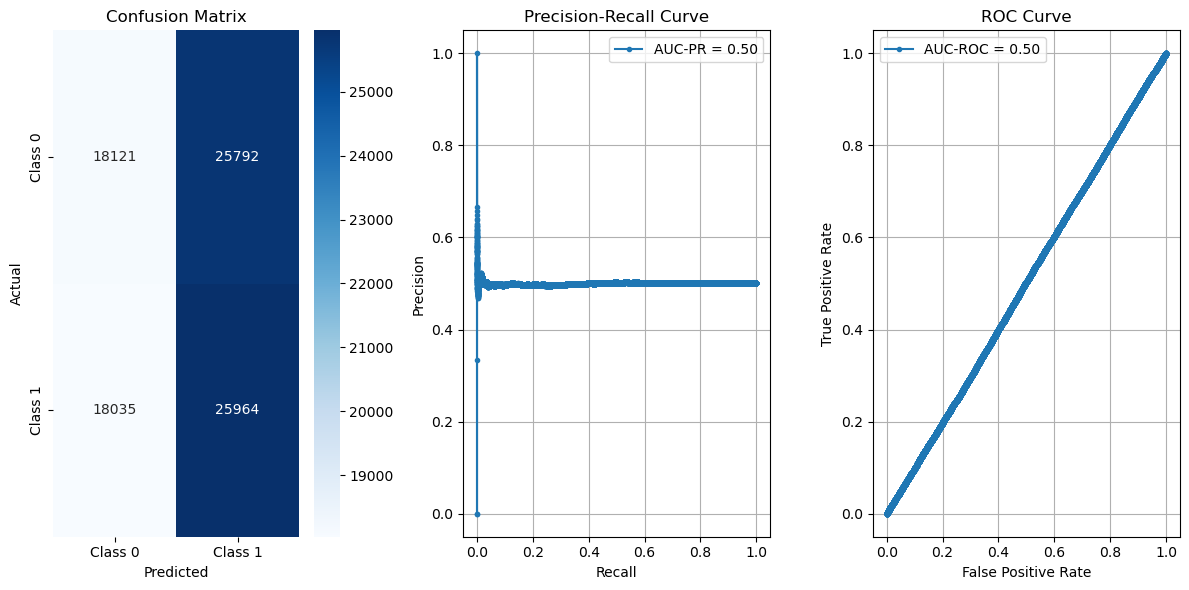


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.50      0.41      0.45     43913
     Class 1       0.50      0.59      0.54     43999

    accuracy                           0.50     87912
   macro avg       0.50      0.50      0.50     87912
weighted avg       0.50      0.50      0.50     87912



In [98]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    auc,
    matthews_corrcoef,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities
y_pred_proba = model.predict(X_test)  # Predicted probabilities for the positive class
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# F1-Score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.2f}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

# AUC-PR (Precision-Recall Curve)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.2f}")

# AUC-ROC (Receiver Operating Characteristic Curve)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc_roc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Plot Precision-Recall Curve
plt.subplot(1, 3, 2)
plt.plot(recall, precision, marker='.', label=f"AUC-PR = {auc_pr:.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()

# Plot ROC Curve
plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.2f}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))


## Save the Trained Model

In [99]:
import os
from datetime import datetime

# Generate a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Ensure the "saved_models" directory exists
os.makedirs("saved_models", exist_ok=True)
# Save the model with the timestamp in the filename
model.save(f"saved_models/Phishing_Email_Classifier_Model_{timestamp}.h5")

## Save the Cleaned Dataset

In [100]:
# Save the DataFrame to a CSV file with the timestamp in the filename
import os
from datetime import datetime

# Generate a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Ensure the "saved_models" directory exists
os.makedirs("saved_data", exist_ok=True)
df.to_csv(f"saved_data/Final_Cleaned_Data_{timestamp}.csv", index=False)


## Deploy the Model (Optional)

    Convert the model to a TensorFlow SavedModel or ONNX for deployment.
    Integrate with a web API or email security system.

## Demo app building

#### On the app showdetales of feature extractio details like:
    1. Address Bar based Features 
    • Domain of URL 
    • IP Address in URL 
    • "@" Symbol in URL 
    • Length of URL 
    • Depth of URL 
    • Redirection "//" in URL 
    • "http/https" in Domain name 
    • Using URL Shortening Services “TinyURL” 
    • Prefix or Suffix "-" in Domain
    2. Domain based Features 
        ◦ DNS Record 
        ◦ Website Traffic 
        ◦ Age of Domain 
        ◦ End Period of Domain 
    3. HTML & Javascript based Features 
    • IFrame Redirection 
    • Status Bar Customization 
    • Disabling Right Click 
    • Website Forwarding 

Phishing database lookup